In [1]:
from fastai.vision.all import *
import timm

## Visualize an example image

In [2]:
path = Path.BASE_PATH = Path.home()/'paddy'
trn_path = path/'train_images'
bls_path = trn_path/'bacterial_leaf_streak'

In [3]:
path.ls()

(#5) [Path('train_images'),Path('train.csv'),Path('sample_submission.csv'),Path('paddy-disease-classification.zip'),Path('test_images')]

In [4]:
trn_path.ls()

(#10) [Path('train_images/bacterial_leaf_streak'),Path('train_images/hispa'),Path('train_images/normal'),Path('train_images/blast'),Path('train_images/dead_heart'),Path('train_images/bacterial_leaf_blight'),Path('train_images/tungro'),Path('train_images/bacterial_panicle_blight'),Path('train_images/brown_spot'),Path('train_images/downy_mildew')]

In [5]:
bls_path.ls()

(#380) [Path('train_images/bacterial_leaf_streak/100081.jpg'),Path('train_images/bacterial_leaf_streak/104135.jpg'),Path('train_images/bacterial_leaf_streak/108249.jpg'),Path('train_images/bacterial_leaf_streak/100235.jpg'),Path('train_images/bacterial_leaf_streak/105265.jpg'),Path('train_images/bacterial_leaf_streak/109925.jpg'),Path('train_images/bacterial_leaf_streak/106054.jpg'),Path('train_images/bacterial_leaf_streak/103307.jpg'),Path('train_images/bacterial_leaf_streak/106974.jpg'),Path('train_images/bacterial_leaf_streak/101151.jpg')...]

In [6]:
train_df = pd.read_csv(path/'train.csv')
train_df

,image_id,label,variety,age
0,100330.jpg,bacterial_leaf_blight,ADT45,45
1,100365.jpg,bacterial_leaf_blight,ADT45,45
2,100382.jpg,bacterial_leaf_blight,ADT45,45
3,100632.jpg,bacterial_leaf_blight,ADT45,45
4,101918.jpg,bacterial_leaf_blight,ADT45,45
...,...,...,...,...
10402,107607.jpg,tungro,Zonal,55
10403,107811.jpg,tungro,Zonal,55
10404,108547.jpg,tungro,Zonal,55
10405,110245.jpg,tungro,Zonal,55


In [7]:
train_df.variety.value_counts()

ADT45             6992
KarnatakaPonni     988
Ponni              657
AtchayaPonni       461
Zonal              399
AndraPonni         377
Onthanel           351
IR20               114
RR                  36
Surya               32
Name: variety, dtype: int64

In [8]:
print(f"The goal is to be able to predict which of the {train_df.label.unique().size} diseases the plant has!!!")
train_df.label.value_counts()

The goal is to be able to predict which of the 10 diseases the plant has!!!


normal                      1764
blast                       1738
hispa                       1594
dead_heart                  1442
tungro                      1088
brown_spot                   965
downy_mildew                 620
bacterial_leaf_blight        479
bacterial_leaf_streak        380
bacterial_panicle_blight     337
Name: label, dtype: int64

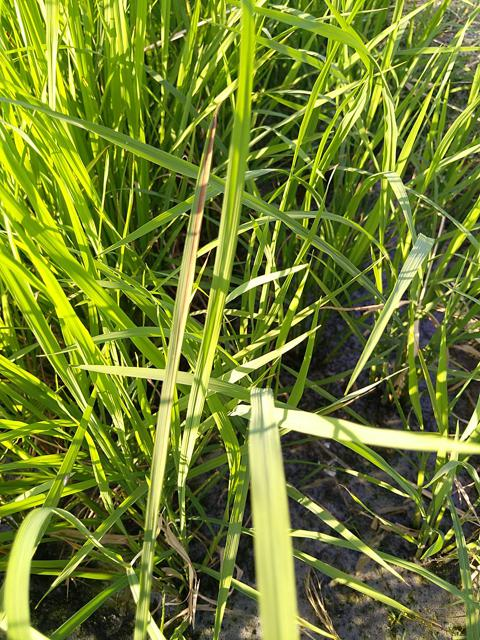

In [9]:
img = PILImage.create(bls_path/'100081.jpg')
img

In [10]:
img_sizes = []
shape_1 = 0
shape_2 = 0
for o in get_image_files(trn_path):
    img = PILImage.create(o)
    img_sizes.append(img.size)
    if img.size == (480, 640):
        shape_1 += 1
    else:
        shape_2 += 1

print(f"shape_1: {shape_1}, shape_2: {shape_2}", set(img_sizes))

shape_1: 10403, shape_2: 4 {(480, 640), (640, 480)}


We have two sets of dimensions 480 * 640 and 640 * 480, only 4 are of shape_2, we should just resize them

## DataLoader From Folders

In [11]:
dls = ImageDataLoaders.from_folder(path=trn_path, valid_pct=0.2, seed=42, item_tfms=Resize(224), bs=32)

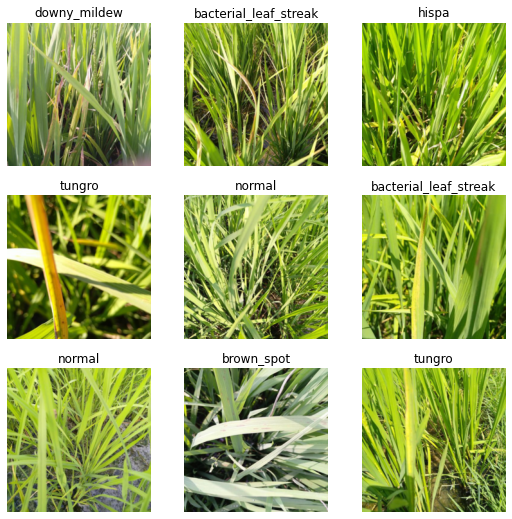

In [12]:
dls.show_batch()

In [13]:
convnext_list = []
for item in timm.list_models():
    if 'convnext' in item:
        convnext_list.append(item)
convnext_list

['convnext_atto',
 'convnext_atto_ols',
 'convnext_base',
 'convnext_base_384_in22ft1k',
 'convnext_base_in22ft1k',
 'convnext_base_in22k',
 'convnext_femto',
 'convnext_femto_ols',
 'convnext_large',
 'convnext_large_384_in22ft1k',
 'convnext_large_in22ft1k',
 'convnext_large_in22k',
 'convnext_nano',
 'convnext_nano_ols',
 'convnext_pico',
 'convnext_pico_ols',
 'convnext_small',
 'convnext_small_384_in22ft1k',
 'convnext_small_in22ft1k',
 'convnext_small_in22k',
 'convnext_tiny',
 'convnext_tiny_384_in22ft1k',
 'convnext_tiny_hnf',
 'convnext_tiny_in22ft1k',
 'convnext_tiny_in22k',
 'convnext_xlarge_384_in22ft1k',
 'convnext_xlarge_in22ft1k',
 'convnext_xlarge_in22k']

In [24]:
# The mixed precision should train faster on a newer GPU kind of card, not really helpful on Paperspace
learn = vision_learner(dls, 'convnext_small_in22k', metrics=error_rate).to_fp16()

In [25]:
learn.fine_tune(12)

epoch,train_loss,valid_loss,error_rate,time
0,1.013509,0.560979,0.189813,00:44


epoch,train_loss,valid_loss,error_rate,time
0,0.562878,0.307243,0.105718,01:00
1,0.408558,0.252653,0.088419,01:01
2,0.340807,0.193347,0.070639,01:01
3,0.250689,0.162861,0.049976,01:01
4,0.196910,0.149404,0.043729,01:01
5,0.139169,0.135732,0.038924,01:01
6,0.108479,0.134621,0.033157,01:01
7,0.096911,0.124724,0.032677,01:01
8,0.071797,0.123772,0.031716,01:01
9,0.050487,0.126114,0.031235,01:01


## Inference

In [26]:
tst_files = get_image_files(path/'test_images').sorted()

In [27]:
doc(get_image_files)

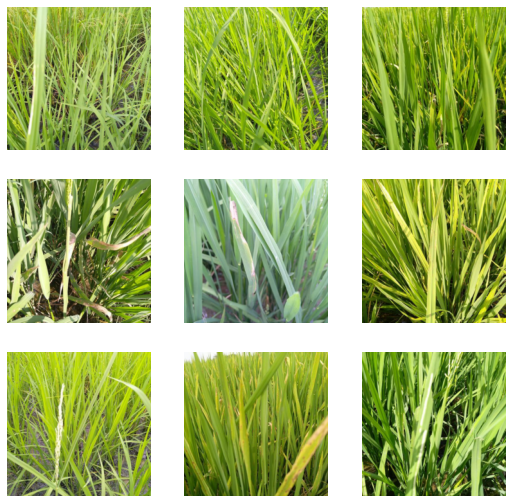

In [28]:
tst_dl = dls.test_dl(tst_files)
tst_dl.show_batch()

Nice as we can see we load into the dataloader the test set, no lables are present!!!

In [29]:
doc(learn.get_preds)

In [30]:
probs, _, idxs = learn.get_preds(dl=tst_dl, with_decoded=True)
idxs = pd.Series(idxs.numpy(), name="idxs")
idxs

0       7
1       8
2       3
3       3
4       3
       ..
3464    5
3465    7
3466    8
3467    1
3468    5
Name: idxs, Length: 3469, dtype: int64

In [31]:
mapping = {k:v for k, v in enumerate(dls.vocab)}
results = idxs.map(mapping)
results

0                       hispa
1                      normal
2                       blast
3                       blast
4                       blast
                ...          
3464               dead_heart
3465                    hispa
3466                   normal
3467    bacterial_leaf_streak
3468               dead_heart
Name: idxs, Length: 3469, dtype: object

## Submission

In [32]:
ss = pd.read_csv(path/'sample_submission.csv')
ss['label'] = results
ss.to_csv('subm.csv', index=False)

In [33]:
ss

,image_id,label
0,200001.jpg,hispa
1,200002.jpg,normal
2,200003.jpg,blast
3,200004.jpg,blast
4,200005.jpg,blast
...,...,...
3464,203465.jpg,dead_heart
3465,203466.jpg,hispa
3466,203467.jpg,normal
3467,203468.jpg,bacterial_leaf_streak


In [34]:
# Copy paste this in the terminal, doesn't work from the notebook, I'll fix it
# !kaggle competitions submit -f subm.csv -m 'convnext_small_in22k ft 2 epoch' paddy-disease-classification